In [3]:
import pandas as pd

sales = pd.read_csv('sales_train_validation.csv')
calendar = pd.read_csv('calendar.csv')
prices = pd.read_csv('sell_prices.csv')

print("Sales Data:")
print(sales.head())
print("\nCalendar Data:")
print(calendar.head())
print("\nPrices Data:")
print(prices.head())

Sales Data:
                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_validation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_validation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_validation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_validation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_validation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1904  d_1905  d_1906  d_1907  d_1908  \
0       CA    0    0    0    0  ...       1       3       0       1       1   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       2       1       2       1       1   
3       CA    0    0    0    0  ...       1       0       5       4       1   
4       CA    0    0    0    0  ...       2       1       1       0       1   

   d_1909  d_1910  d_1911  d_191

In [5]:
sales_long = sales.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                        var_name='d', value_name='sales')

calendar['date'] = pd.to_datetime(calendar['date'])
calendar = calendar[['d', 'wm_yr_wk', 'date']]
df = sales_long.merge(calendar, on='d', how='left')
df = df.merge(prices, on=['store_id', 'item_id', 'wm_yr_wk'], how='left')
df = df[['date', 'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'sales', 'sell_price']]
df.head()

,date,id,item_id,dept_id,cat_id,store_id,sales,sell_price
0,2011-01-29,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,NaN
1,2011-01-29,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,NaN
2,2011-01-29,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,NaN
3,2011-01-29,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,0,NaN
4,2011-01-29,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,0,NaN


In [7]:
df['lag_7'] = df['sales'].shift(7)
df['lag_14'] = df['sales'].shift(14)
df['lag_28'] = df['sales'].shift(28)
df['rolling_mean_7'] = df['sales'].shift(1).rolling(window=7).mean()
df['rolling_mean_14'] = df['sales'].shift(1).rolling(window=14).mean()
df.dropna(inplace=True)

df.head()

,date,id,item_id,dept_id,cat_id,store_id,sales,sell_price,lag_7,lag_14,lag_28,rolling_mean_7,rolling_mean_14
28,2011-01-29,HOBBIES_1_029_CA_1_validation,HOBBIES_1_029,HOBBIES_1,HOBBIES,CA_1,2,7.44,2.0,4.0,0.0,0.571429,0.928571
31,2011-01-29,HOBBIES_1_032_CA_1_validation,HOBBIES_1_032,HOBBIES_1,HOBBIES,CA_1,9,0.47,0.0,0.0,0.0,0.285714,0.428571
35,2011-01-29,HOBBIES_1_036_CA_1_validation,HOBBIES_1_036,HOBBIES_1,HOBBIES,CA_1,2,0.96,2.0,2.0,12.0,1.571429,1.071429
37,2011-01-29,HOBBIES_1_038_CA_1_validation,HOBBIES_1_038,HOBBIES_1,HOBBIES,CA_1,0,3.17,0.0,0.0,0.0,1.571429,0.928571
43,2011-01-29,HOBBIES_1_044_CA_1_validation,HOBBIES_1_044,HOBBIES_1,HOBBIES,CA_1,3,1.51,0.0,0.0,5.0,0.000000,0.785714


In [17]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

product_data = df[df['id']== df['id'].unique()[0]]
features = ['lag_7', 'lag_14','lag_14','rolling_mean_7','rolling_mean_7', 'sell_price']
X = product_data[features]
y = product_data['sales']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Test RMSE: {rmse:.2f}")

Test RMSE: 2.02


In [25]:
current_inventory = 100

# Predict next 7 days
future_pred = model.predict(X_test[-7:])
forecasted_demand = sum(future_pred)

print(f"Forecasted 7-day demand: {forecasted_demand:.0f}")
if forecasted_demand > current_inventory:
    print("⚠️  Restock Alert: Projected demand exceeds current inventory!")
else:
    print("✅ Inventory level is sufficient.")

Forecasted 7-day demand: 8
✅ Inventory level is sufficient.


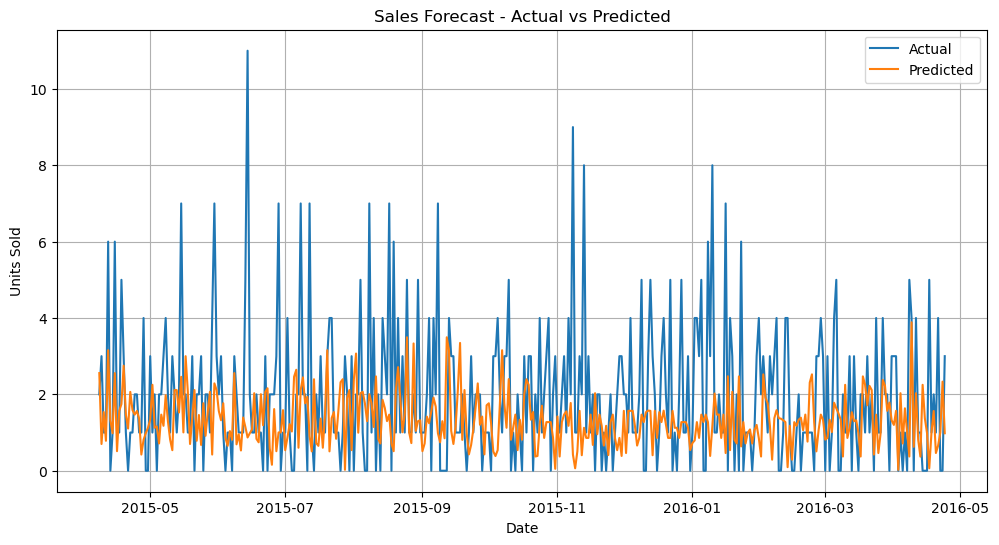

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(product_data['date'].iloc[-len(y_test):], y_test.values, label='Actual')
plt.plot(product_data['date'].iloc[-len(y_test):], y_pred, label='Predicted')
plt.title("Sales Forecast - Actual vs Predicted")
plt.xlabel("Date")
plt.ylabel("Units Sold")
plt.legend()
plt.grid()
plt.show()

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler

sales_long = sales.melt(id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'],
                        var_name='d', value_name='sales')
calendar['date'] = pd.to_datetime(calendar['date'])
df = sales_long.merge(calendar, on='d', how='left')
df = df[['date', 'id', 'sales']]
df = df[df['id'] == df['id'].unique()[0]].sort_values('date')

# Prepare time series
data = df['sales'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

SEQ_LEN = 30
X, y = create_sequences(scaled_data, SEQ_LEN)

# Train/test split
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# Build LSTM model
model = Sequential([
    LSTM(64, activation='relu', input_shape=(SEQ_LEN, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32)

# Forecast next 7 days
last_sequence = scaled_data[-SEQ_LEN:].reshape(1, SEQ_LEN, 1)
future_predictions = []
current_seq = last_sequence

for _ in range(7):
    pred = model.predict(current_seq)[0][0]
    future_predictions.append(pred)
    current_seq = np.append(current_seq[:, 1:, :], [[[pred]]], axis=1)

# Invert scaling
future_sales = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()
print("7-Day Forecast:", future_sales)


Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0138
Epoch 2/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0110
Epoch 3/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0109
Epoch 4/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0093
Epoch 5/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0103
Epoch 6/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0117
Epoch 7/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0100
Epoch 8/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0098
Epoch 9/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0096
Epoch 10/10
48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0090
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7-Day Forecast: [0.8961983  0.892888   0.8913137  0.8933598  0.91272056 0.931365
 0.94880015]


12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


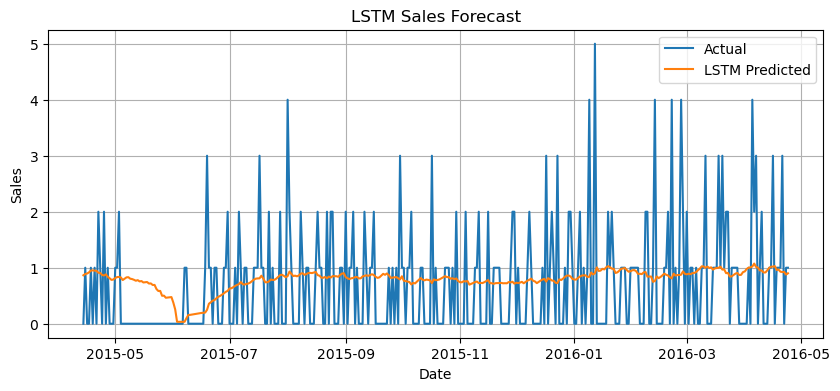

In [6]:
plt.figure(figsize=(10, 4))
plt.plot(df['date'].values[-len(y_test):], scaler.inverse_transform(y_test), label='Actual')
plt.plot(df['date'].values[-len(y_test):], scaler.inverse_transform(model.predict(X_test)), label='LSTM Predicted')
plt.title('LSTM Sales Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.show()

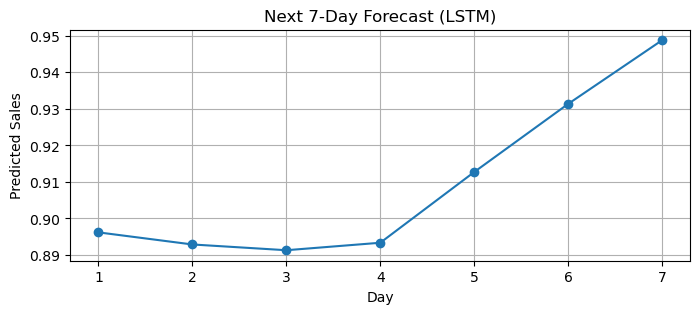

In [8]:
# Future forecast
plt.figure(figsize=(8, 3))
plt.plot(range(1, 8), future_sales, marker='o')
plt.title("Next 7-Day Forecast (LSTM)")
plt.xlabel("Day")
plt.ylabel("Predicted Sales")
plt.grid()
plt.show()